In [52]:
import pandas as pd
import numpy as np
import re

# 1 Load evaluation data
df = pd.read_excel('./evaluacion.xlsx')

# 2. Filtrar agentes de Ollama (“dual” o “llama”)
df = df[~df['agent'].str.contains(r'(dual|llama)', flags=re.I, na=False)]

# 3. Calcular medias de access / adequacy (ignorando NaN)
access_cols   = [c for c in df.columns if 'access'   in c.lower() or 'acceso'   in c.lower()]
adequacy_cols = [c for c in df.columns if 'adequacy' in c.lower() or 'adecuación' in c.lower()]

df['access_avg']   = df[access_cols].mean(axis=1, skipna=True) if access_cols else np.nan
df['adequacy_avg'] = df[adequacy_cols].mean(axis=1, skipna=True) if adequacy_cols else np.nan

# 4. Agrupar por agente
summary = (
    df.groupby('agent', dropna=False)
      .agg(turns=('agent', 'count'),
           access_mean=('access_avg', 'mean'),
           adequacy_mean=('adequacy_avg', 'mean'),
           tokens_total=('tokens', 'sum',) if 'tokens' in df.columns else ('agent', 'size'),
           time_total_s=('time', 'sum')   if 'time'   in df.columns else ('agent', 'size')
          )
      .reset_index()
)

# 5. Calcular coste (heurística simple)
prices = {'claude': (3.0, 15.0), 'gemini': (0.15, 0.5), 'mistral': (2.0, 6.0)}
def coste(row):
    a = row['agent'].lower()
    if a.startswith('gpt'):
        return 20/(8*4)
    if 'tokens' not in df.columns or pd.isna(row.get('tokens_total')):
        return np.nan
    tin, tout = row['tokens_total']*0.6, row['tokens_total']*0.4
    pi, po = prices.get(a, (0,0))
    return tin/1e6*pi + tout/1e6*po

if 'tokens' in df.columns:
    summary['cost_usd'] = summary.apply(coste, axis=1)

# Latencia media (si existe)
if 'time_total_s' in summary.columns:
    summary['latency_s'] = summary['time_total_s'] / summary['turns']

C:\Users\dandr\AppData\Local\Temp\ipykernel_26304\2801380677.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['agent'].str.contains(r'(dual|llama)', flags=re.I, na=False)]


In [26]:
summary.round(3)

,agent,turns,access_mean,adequacy_mean,tokens_total,time_total_s,cost_usd,latency_s
0,GPT,10,1.625,7.800,0.0,422.00,NaN,42.200
1,claude,9,1.857,7.125,152690.0,542.00,1.191,60.222
2,gemini,15,1.625,6.192,121604.0,153.40,0.035,10.227
3,mistral,14,0.000,4.192,89552.0,155.58,0.322,11.113


In [55]:
print(summary)

     agent  turns  access_mean  adequacy_mean  tokens_total  time_total_s  \
0      GPT     10     1.625000       7.800000           0.0        422.00   
1   claude      9     1.857143       7.125000      152690.0        542.00   
2   gemini     15     1.625000       6.192308      121604.0        153.40   
3  mistral     14     0.000000       4.192308       89552.0        155.58   

   cost_usd  latency_s  
0  0.625000  42.200000  
1  1.190982  60.222222  
2  0.035265  10.226667  
3  0.322387  11.112857  


## Gráficos

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

custom_style = {
    "font.family": "sans-serif",
    "font.size": 13,
    "axes.titlesize": 18,
    "axes.labelsize": 13,
    "axes.prop_cycle": plt.cycler(color=["#f5a623"]),
    "patch.edgecolor": "none",
    "axes.grid": True,
    "grid.color": "grey",
    "grid.linestyle": ":",
    "grid.linewidth": 0.7,
    "grid.alpha": 0.5,
    "figure.autolayout": True,
}

mpl.style.core.USER_LIBRARY_PATHS  
mpl.style.library["grantlamp"] = custom_style   
mpl.style.use("grantlamp")                     

AGENT_COLORS = {
    "GPT":    "#2ecc71",  
    "claude": "#f5a623",  
    "gemini": "#3498db",  
    "mistral": "#9b59b6"  
}

from itertools import cycle
mpl.rcParams["axes.prop_cycle"] = plt.cycler(color=list(AGENT_COLORS.values()))


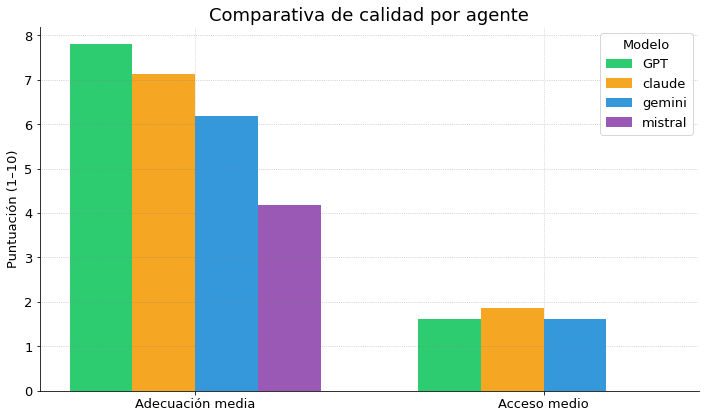

In [54]:
# ── datos de ejemplo (usa tu summary real) ──────────────────────────────────
categories = ["adequacy_mean", "access_mean"]  # dos métricas a comparar
agents     = ["GPT", "claude", "gemini", "mistral"]

# Extrae los valores en el mismo orden (summary es tu DF agregado)
vals = {m: summary.set_index("agent").loc[m, categories].values for m in agents}

# ── construcción del gráfico de barras agrupadas ───────────────────────────
x      = np.arange(len(categories))         # posiciones de los grupos
width  = 0.18                               # ancho de cada barra
offset = np.linspace(-1.5, 1.5, len(agents))*width  # desplazamientos

fig, ax = plt.subplots(figsize=(10, 6))

for i, agent in enumerate(agents):
    ax.bar(x + offset[i],
           vals[agent],
           width,
           label=agent,
           color=AGENT_COLORS[agent])

# Estética coherente
ax.set_xticks(x, ["Adecuación media", "Acceso medio"])
ax.set_ylabel("Puntuación (1–10)")
ax.set_title("Comparativa de calidad por agente")
ax.grid(axis="y", linestyle=":", alpha=0.6)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.legend(title="Modelo")
plt.tight_layout()
plt.show()


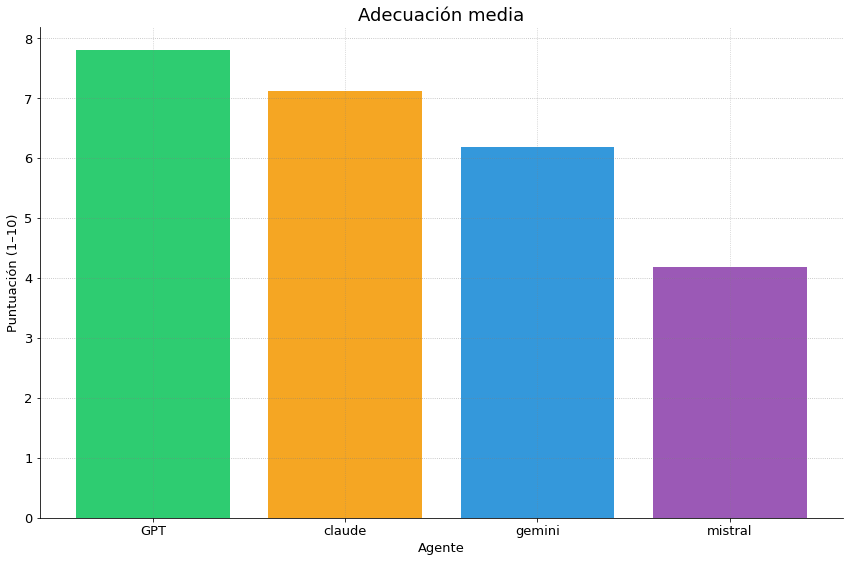

In [46]:
colors = [AGENT_COLORS[a] for a in summary["agent"]]
plt.figure(figsize=(12, 8))
plt.bar(summary['agent'], summary['adequacy_mean'], color=colors)
plt.title('Adecuación media')
plt.ylabel('Puntuación (1–10)')
plt.xlabel('Agente')
# Cuadrícula discontinua y solo en eje Y (igual que el segundo gráfico)
plt.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.6)

# Eliminar bordes superior y derecho
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


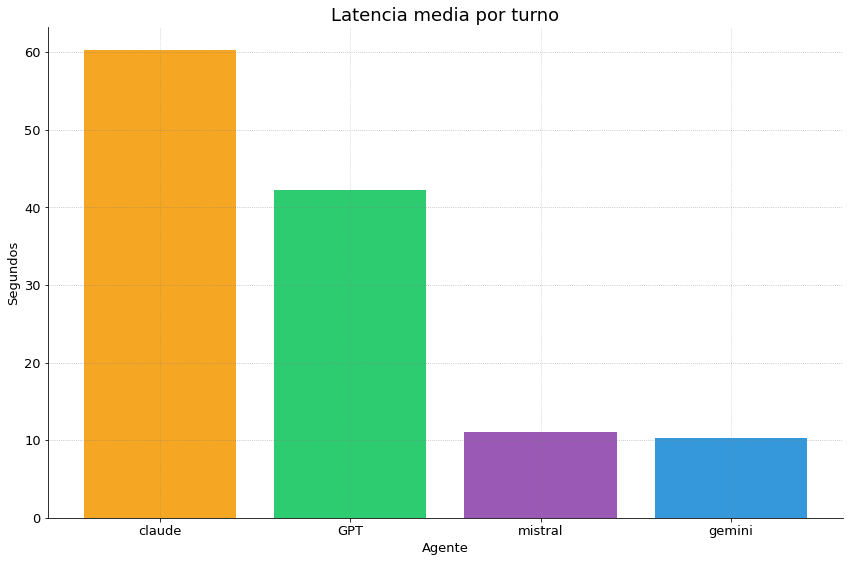

In [48]:
ordered = summary.sort_values('latency_s', ascending=False)
colors = [AGENT_COLORS[a] for a in ordered["agent"]]

plt.figure(figsize=(12, 8))
plt.bar(ordered['agent'], ordered['latency_s'], color=colors)
plt.title('Latencia media por turno')
plt.ylabel('Segundos')
plt.xlabel('Agente')
plt.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.6)
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)
plt.tight_layout()
plt.show()



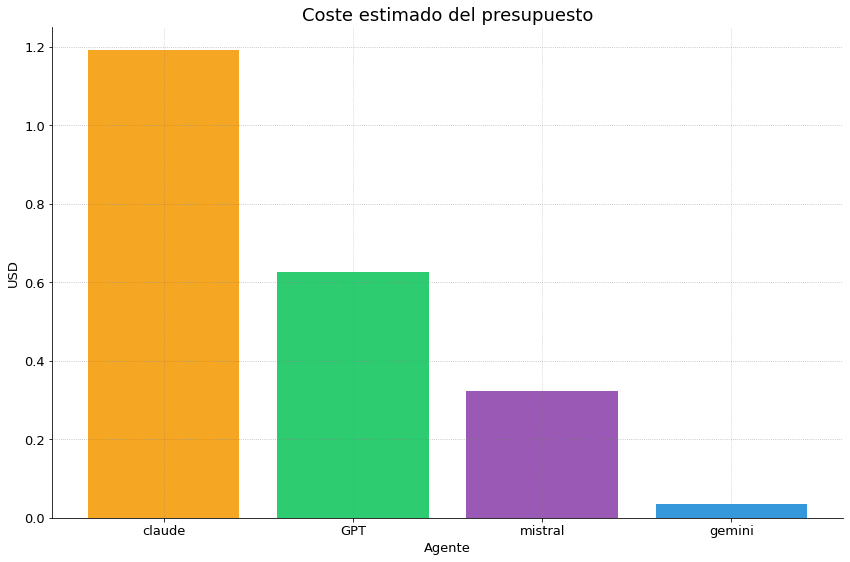

In [53]:
ordered = summary.sort_values('cost_usd', ascending=False)
colors = [AGENT_COLORS[a] for a in ordered["agent"]]

plt.figure(figsize=(12, 8))
plt.bar(ordered['agent'], ordered['cost_usd'], color=colors)
plt.title('Coste estimado del presupuesto')
plt.ylabel('USD')
plt.xlabel('Agente')
plt.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.6)
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()
